# Time Series with Facebook Prophet

In [1]:
import pandas as pd
import numpy as np

from pathlib import Path

import os, sys
sys.path.insert(0, os.path.abspath('../src'))

from utils import *
from fbp import ProphetModel

In [2]:
data_path = "../data"

In [3]:
DataDownloader(data_path).download_all_csv()

In [4]:
covidpro_df, dpc_regioni_df, _, _, _ = load_data(data_path)

## Provincial

### New cases

In [5]:
province = "Firenze"
compart = "New_cases"
date = 'Date'
group_column = 'Province'

In [6]:
pm = ProphetModel(data=covidpro_df, 
                  area=province, 
                  compart=compart, 
                  group_column=group_column,
                  date_column=date)

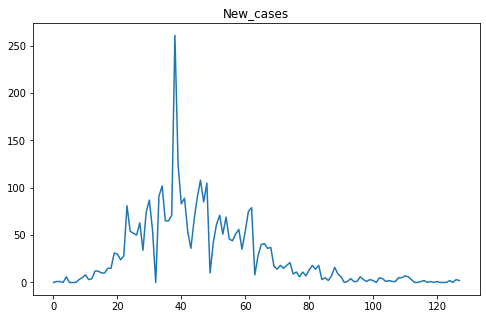

In [7]:
pm.plot_data()

In [8]:
pm.fit()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


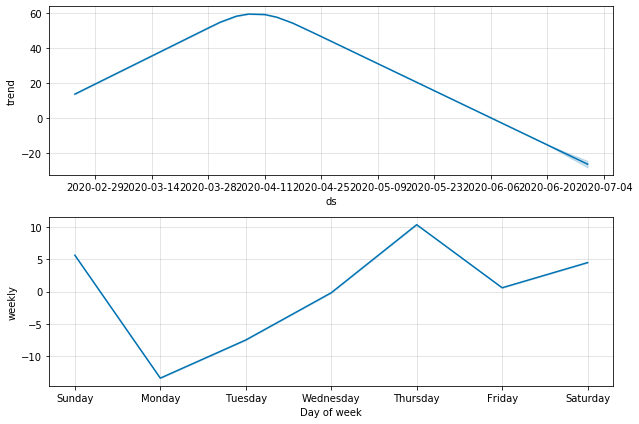

In [9]:
pm.plot_comp()

In [10]:
pm.print_metrics()

MAE: 17.221
MSE: 687.324
RMSE: 26.217


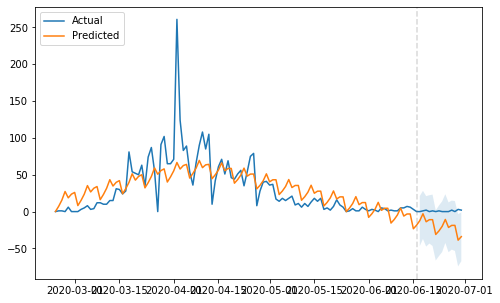

In [11]:
pm.plot()

In [12]:
# Tune the hyperparameters and fit
pm.fit_cv()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-05-19 00:00:00 and 2020-06-16 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f895239d0d0>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-05-19 00:00:00 and 2020-06-16 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f894ddbf1f0>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet wit

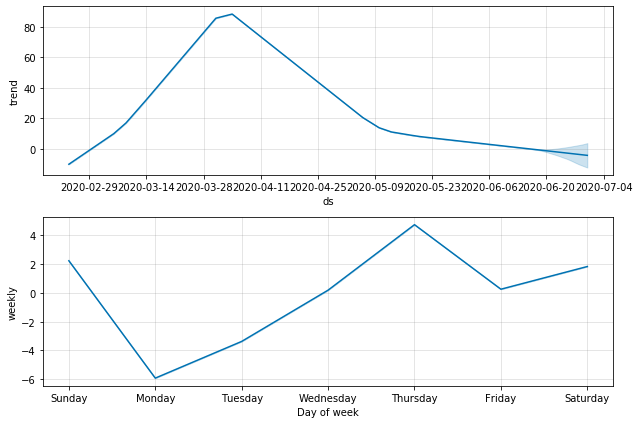

In [13]:
pm.plot_comp()

In [14]:
pm.print_metrics()

MAE: 10.202
MSE: 424.038
RMSE: 20.592


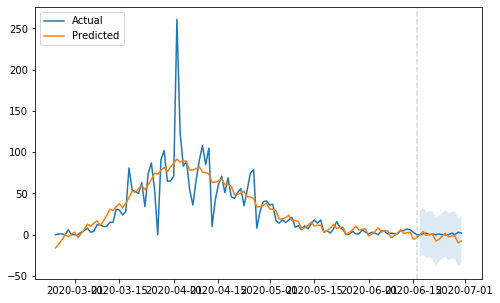

In [15]:
pm.plot()

### Deaths

In [16]:
province = "Firenze"
compart = "Deaths"
date = 'Date'
group_column = 'Province'

In [17]:
pm = ProphetModel(data=covidpro_df, 
                  area=province, 
                  compart=compart, 
                  group_column=group_column,
                  date_column=date)

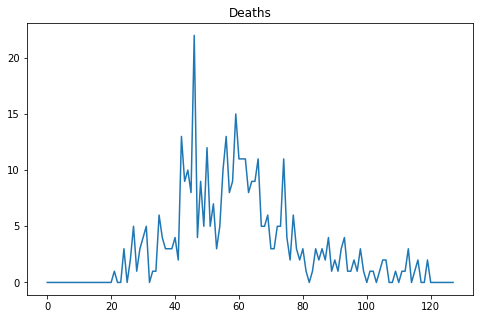

In [18]:
pm.plot_data()

In [19]:
pm.fit_cv()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-05-19 00:00:00 and 2020-06-16 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f89523ba4c0>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-05-19 00:00:00 and 2020-06-16 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f894dd60ac0>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet wit

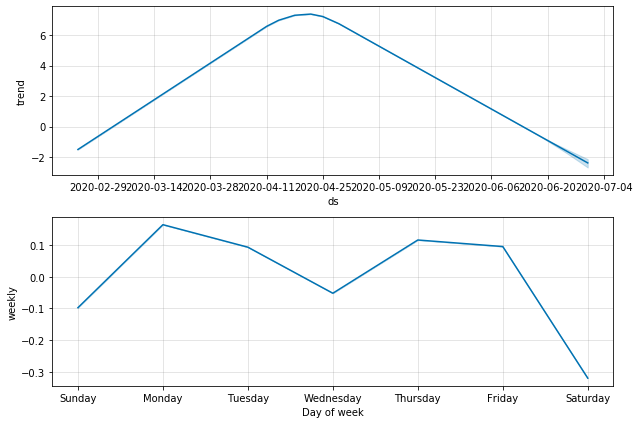

In [20]:
pm.plot_comp()

In [21]:
pm.print_metrics()

MAE: 1.889
MSE: 6.931
RMSE: 2.633


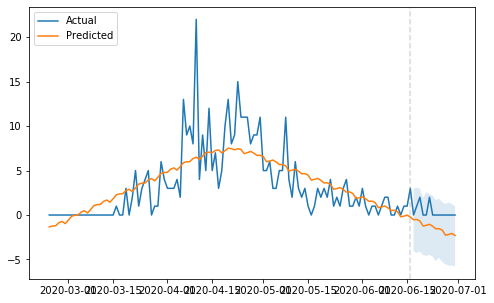

In [22]:
pm.plot()

## Regional

### New cases

In [23]:
province = "Lombardia"
compart = "nuovi_positivi"
date = 'data'
group_column = 'denominazione_regione'

In [30]:
pm = ProphetModel(data=dpc_regioni_df, 
                  area=province, 
                  compart=compart, 
                  group_column=group_column,
                  date_column=date,
                  query='20200701 > data')

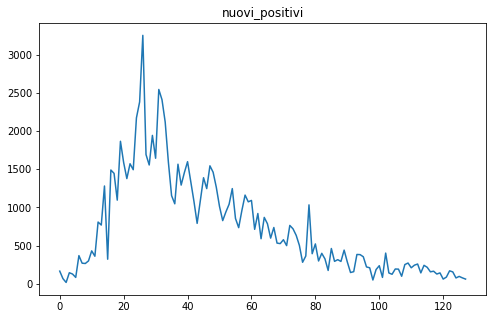

In [31]:
pm.plot_data()

In [32]:
pm.fit_cv()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-05-19 00:00:00 and 2020-06-16 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f8975a88640>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2020-05-19 00:00:00 and 2020-06-16 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f89780469d0>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet 

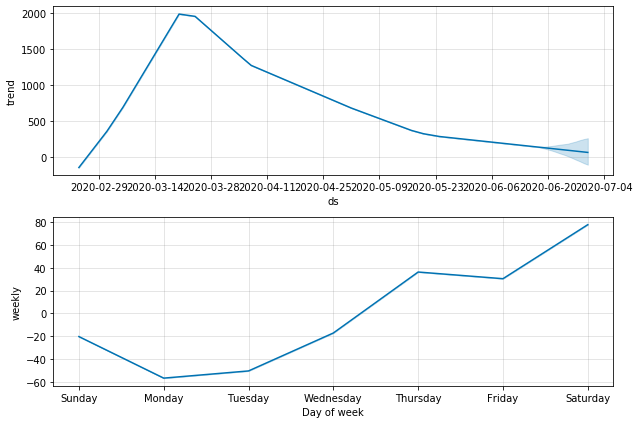

In [33]:
pm.plot_comp()

In [34]:
pm.print_metrics()

MAE: 154.581
MSE: 51532.572
RMSE: 227.008


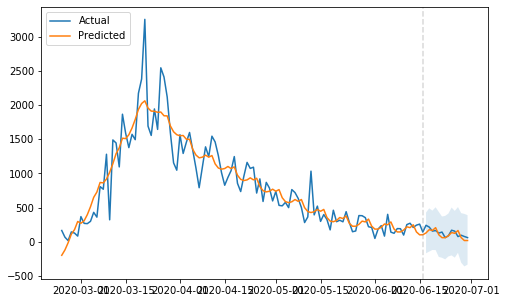

In [35]:
pm.plot()